<a href="https://colab.research.google.com/github/iamfaham/model-inference-profiler/blob/main/model_inference_profiler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Inference Profiler
This notebook demonstrates how to profile a PyTorch model.

### Install torchinfo

Installs the `torchinfo` library for model summaries.

In [1]:
!pip install torchinfo --quiet

### Import Libraries

Imports necessary libraries for PyTorch, torchvision models, profiling, and plotting.

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.profiler import profile, record_function, ProfilerActivity
import matplotlib.pyplot as plt
from torchinfo import summary


### Load Pretrained Model

Loads a pretrained model, sets it to evaluation mode, moves it to CUDA, and prints a summary.

In [28]:
# Load a pretrained model
model = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)        # Change for other models
model.eval().cuda()

# Print model summary
summary(model, (1, 3, 224, 224))


Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [1, 1000]                 768
├─Conv2d: 1-1                                 [1, 768, 14, 14]          590,592
├─Encoder: 1-2                                [1, 197, 768]             151,296
│    └─Dropout: 2-1                           [1, 197, 768]             --
│    └─Sequential: 2-2                        [1, 197, 768]             --
│    │    └─EncoderBlock: 3-1                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-2                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-3                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-4                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-5                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-6                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-7             

### Prepare Dummy Input and Warm-up

Creates a dummy input tensor, moves it to CUDA, and runs it through the model for warm-up.

In [24]:
# Dummy input
dummy_input = torch.randn(1, 3, 224, 224).cuda()

# Warm-up
for _ in range(10):
    _ = model(dummy_input)


### Profile Model Inference

Profiles the model inference for CPU and CUDA activities, shapes, and memory usage. Prints a table of top CUDA time operations.

In [25]:
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
             record_shapes=True,
             with_stack=False,
             profile_memory=True) as prof:
    with record_function("model_inference"):
        _ = model(dummy_input)

# Print top 15 time-consuming ops
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=15))


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference         0.00%       0.000us         0.00%       0.000us       0.000us       9.407ms       101.68%       9.407ms       9.407ms           0 B           0 B           0 B           0 

### Visualize Top 15 Layers by CUDA Time

Extracts and plots the top 15 layers by CUDA time from the profiler results.

/tmp/ipython-input-1677181912.py:4: FutureWarning: `cuda_time` is deprecated, please use `device_time` instead.
  cuda_times = [e.cuda_time / 1000.0 for e in events]  # to ms


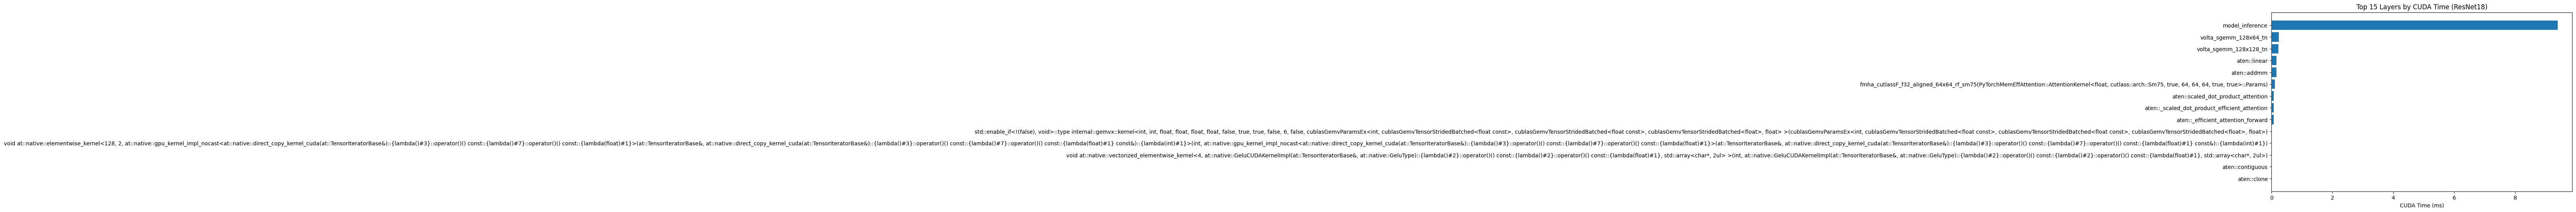

In [26]:
# Convert profiler results to a list of (name, cuda_time)
events = prof.key_averages()
layer_names = [e.key for e in events]
cuda_times = [e.cuda_time / 1000.0 for e in events]  # to ms

# Sort and take top 15
sorted_pairs = sorted(zip(layer_names, cuda_times), key=lambda x: x[1], reverse=True)[:15]
layers, times = zip(*sorted_pairs)

plt.figure(figsize=(10, 6))
plt.barh(layers[::-1], times[::-1])
plt.xlabel("CUDA Time (ms)")
plt.title("Top 15 Layers by CUDA Time (ResNet18)")
plt.show()

### Visualize Top 15 Layers by Memory Usage

Extracts and plots the top 15 layers by memory usage from the profiler results.

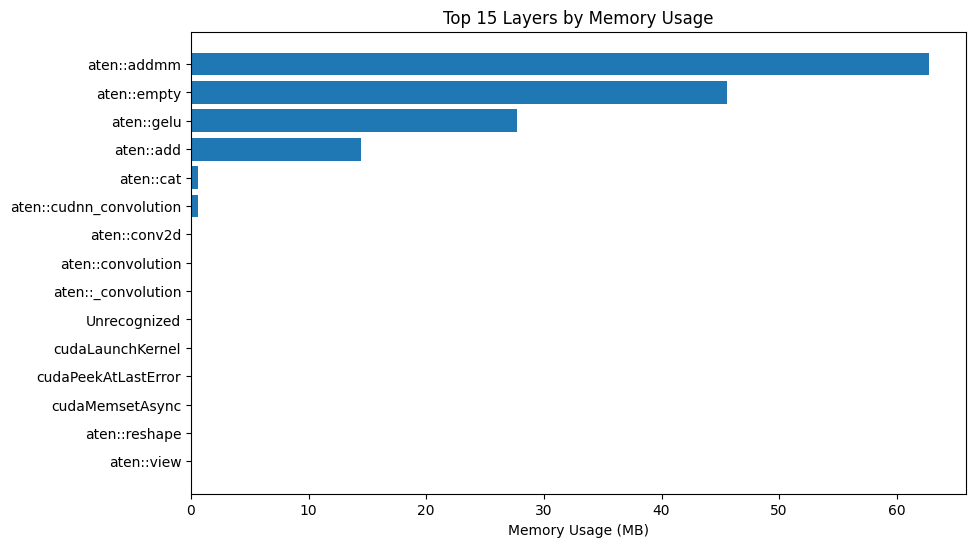

In [27]:
events = prof.key_averages()
# Print attributes of the first event to inspect available attributes
memory = [e.self_device_memory_usage / (1024**2) for e in events]  # MB
names = [e.key for e in events]

sorted_mem = sorted(zip(names, memory), key=lambda x: x[1], reverse=True)[:15]
layers, mems = zip(*sorted_mem)

plt.figure(figsize=(10, 6))
plt.barh(layers[::-1], mems[::-1])
plt.xlabel("Memory Usage (MB)")
plt.title("Top 15 Layers by Memory Usage")
plt.show()